# Allen-Cahn Phase Field Model: Multi-Grain Growth

## 개요

본 노트북은 Allen-Cahn 위상장 모델을 확장하여 **여러 개의 결정(grain)이 동시에 성장하고 경합하는 현상**을 시뮬레이션합니다. Single grain growth와 달리 다중 그레인 모델은 그레인 간의 상호작용 현상을 모델링할 수 있습니다.

---

## 다중 그레인 자유 에너지 함수형식 (Free Energy Functional)

Vector-valued order parameter를 사용하여 확장합니다:

$$\vec{\phi} = (\phi_1, \phi_2, \ldots, \phi_{N_g})$$

여기서 각 $\phi_i$는 $i$번째 그레인을 나타내며, $N_g$는 그레인의 총 개수입니다.

확장된 자유 에너지 함수형식:

$$F[\vec{\phi}] = \sum_{i=1}^{N_g} \int \left[ \frac{\varepsilon^2}{2} |\nabla\phi_i|^2 + \frac{1}{4}(\phi_i^2 - 1)^2 \right] dx + \int \lambda \sum_{i<j} \phi_i^2 \phi_j^2 dx$$

**항의 의미:**

- **그레인별 기본 항**: 각 그레인 $i$에 대해 단일 결정 모델과 동일한 그래디언트 에너지와 이중 우물 포텐셜을 포함합니다.
- **페널티 항** (마지막 항): $\lambda \sum_{i<j} \phi_i^2 \phi_j^2$는 서로 다른 그레인이 같은 위치에서 겹칠 때 에너지를 증가시킵니다. 이를 통해 그레인들 간의 배타적인(exclusive) 점유를 강제합니다.

---

## 다중 그레인 Allen-Cahn 시간 진화 방정식

각 그레인에 대한 시간 진화 방정식:

$$\frac{\partial\phi_i}{\partial t} = M \left[ \varepsilon^2 \Delta\phi_i - (\phi_i^3 - \phi_i) - 2\lambda\phi_i \sum_{j \neq i} \phi_j^2 \right]$$

**방정식의 구성:**

- **첫 번째 항**: 그래디언트 에너지에서 유래한 확산항
- **두 번째 항**: 이중 우물 포텐셜의 변분으로부터 유래
- **페널티 항**: 다른 그레인들의 제곱 합에 비례하는 그레인-그레인 상호작용

**물리적 의미:**

페널티 항은 특정 위치에서 여러 그레인의 $\phi$ 값이 동시에 1에 가까워지는 것을 억제합니다. 이를 통해 그레인들이 공간을 놓고 경합하면서 자연스럽게 도메인이 분할되는 현상을 모델링합니다.

---

## 초기 조건

각 그레인의 초기 상태는 도메인 내 **랜덤한 위치**에서 설정됩니다:

$$\phi_i(x, y, t=0) = \begin{cases}
1 & \text{if } (x-x_{0,i})^2 + (y-y_{0,i})^2 \leq r^2 \\
0 & \text{otherwise}
\end{cases}$$

여기서:
- $(x_{0,i}, y_{0,i})$: $i$번째 그레인의 초기 중심 (도메인 내 랜덤하게 선택)
- $r$: 모든 그레인의 초기 반경 (동일하게 설정)

모든 그레인이 동일한 초기 조건을 가지므로, 시뮬레이션 결과는 그레인들 간의 상호작용과 도메인 구조에만 의존합니다.

---

## 페널티 항의 효과: 그레인-그레인 상호작용

페널티 계수 $\lambda$ (코드에서 `p_coeff`)는 다음과 같이 작용합니다:

- **$\lambda$ 값이 클수록**: 그레인들의 겹침이 더욱 강하게 억제되므로, 도메인 경계가 명확하고 그레인들이 서로 영역을 침범하지 않습니다.
- **$\lambda$ 값이 작을수록**: 그레인 간 상호작용이 약해져, 경계 영역에서 여러 그레인의 $\phi$ 값이 동시에 활성화될 수 있습니다.

현재 시뮬레이션에서는 $\lambda = 2.0$으로 설정하여 그레인들 간의 명확한 경합을 구현합니다.

---

## 시뮬레이션 파라미터 및 물리적 해석

| 파라미터 | 값 | 물리적 의미 |
|---|---|---|
| `N` | 128 | 격자 크기 (128×128 점) |
| `num_grains` | 5 | 그레인 개수 |
| `dx` | 1.0 | 격자 간격 |
| `dt` | 0.01 | 시간 스텝 |
| `nsteps` | 2500 | 총 시뮬레이션 스텝 |
| `grad_coeff` | 0.1 | 그래디언트 계수 $\varepsilon^2$ |
| `mobility` | 5.0 | 이동성 $M$ |
| `p_coeff` | 2.0 | 페널티 항 계수 $\lambda$ |
| `radius` | 5 | 각 그레인의 초기 반경 |
| `save_interval` | 100 | 저장 간격 (매 100 스텝마다 상태 저장) |


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.colors import ListedColormap, Normalize

In [2]:
class MultiGrainGrowthSimulation:
    """Multi-grain 성장 시뮬레이션 클래스 (Allen-Cahn 모델)"""

    def __init__(self, N=128, num_grains=5, dx=1.0, dt=0.01,
                 grad_coeff=0.1, mobility=5.0, p_coeff=2.0,
                 radius=5, pbc_x=True, pbc_y=True, random_seed=None):
        """
        기초 파라미터 설정 및 시뮬레이션 구조 설정

        Parameters
        ----------
        N : int
            그리드 포인트 개수 (N×N)
        num_grains : int
            그레인 개수
        dx : float
            그리드 간격
        dt : float
            시간 스텝
        grad_coeff : float
            그래디언트 계수 (ε²)
        mobility : float
            이동성 (Mobility)
        p_coeff : float
            페널티 항 계수 (Penalty term coefficient)
        radius : int
            초기 원형 영역 반경
        pbc_x : bool
            X 방향 주기 경계 조건
        pbc_y : bool
            Y 방향 주기 경계 조건
        random_seed : int or None
            난수 생성 시드 (재현성을 위해 사용)
        """
        # 파라미터 저장
        self.N = N
        self.num_grains = num_grains
        self.dx = dx
        self.dt = dt
        self.grad_coeff = grad_coeff
        self.mobility = mobility
        self.p_coeff = p_coeff
        self.radius = radius
        self.pbc_x = pbc_x
        self.pbc_y = pbc_y
        self.random_seed = random_seed

        # 난수 시드 설정
        if random_seed is not None:
            np.random.seed(random_seed)

        # 초기화
        self.phi = self._initialize_phi()
        self.step_count = 0

        # 저장된 상태들
        self.phi_history = []  # 저장된 phi 필드 리스트
        self.step_history = []  # 저장된 스텝 번호 리스트

        # 시각화 설정
        self.grain_cmap = self._create_grain_colormap()
        self.grain_norm = Normalize(vmin=-1, vmax=self.num_grains)


    def _initialize_phi(self):
        """
        Order parameter phi 초기화 (Multi-grain)

        각 그레인을 도메인 내 랜덤한 위치에 반경 radius인 원형으로 배치

        Returns
        -------
        np.ndarray
            초기화된 phi 필드 (N×N×num_grains)
        """
        phi = np.zeros((self.N, self.N, self.num_grains))
        X, Y = np.meshgrid(np.arange(self.N), np.arange(self.N))

        # 각 그레인에 대해 랜덤한 위치에 초기 원형 영역 설정
        for i in range(self.num_grains):
            x0 = np.random.randint(0, self.N)
            y0 = np.random.randint(0, self.N)
            mask = (X - x0)**2 + (Y - y0)**2 <= self.radius**2
            phi[mask, i] = 1.0

        return phi


    def _create_grain_colormap(self):
        """
        그레인별 색상 맵 생성

        각 그레인(0~num_grains-1)에 고유한 색상을 할당하는 ListedColormap 생성
        background (값 -1)는 흰색으로 표시

        Returns
        -------
        matplotlib.colors.ListedColormap
            그레인별 색상 맵
        """
        # tab10 colormap에서 색상 추출 (최대 10개 그레인)
        base_cmap = plt.get_cmap('tab10', min(self.num_grains, 10))
        colors = [base_cmap(i) for i in range(self.num_grains)]

        # 배경색(흰색)과 그레인 색상을 합침
        # 인덱스: -1 = 배경(흰색), 0~num_grains-1 = 그레인 색상
        all_colors = [(1.0, 1.0, 1.0)] + colors  # 배경을 맨 앞에

        grain_cmap = ListedColormap(all_colors)
        return grain_cmap


    def _get_grain_field(self, phi_snapshot):
        """
        phi 필드에서 grain_id 필드 생성

        각 위치(i,j)에서 가장 큰 phi 값을 가진 그레인의 인덱스를 반환
        phi의 최댓값이 임계값보다 작으면 배경으로 표시(-1)

        Parameters
        ----------
        phi_snapshot : np.ndarray
            특정 시간의 phi 필드 (N×N×num_grains)

        Returns
        -------
        np.ndarray
            그레인 인덱스 필드 (N×N), 범위: -1(배경) ~ num_grains-1
        """
        # 각 위치에서 최댓값을 가진 그레인 인덱스 찾기
        grain_id = np.argmax(phi_snapshot, axis=2)  # 범위: 0 ~ num_grains-1
        grain_strength = np.max(phi_snapshot, axis=2)  # 각 위치의 최대 phi 값

        # 모든 그레인의 phi가 작으면(< 0.1) 배경으로 표시
        threshold = 0.1
        grain_id = grain_id.astype(float)
        grain_id[grain_strength < threshold] = -1

        return grain_id


    def laplacian(self, phi_2d):
        """
        라플라시안 계산 (Finite Difference Method)
        주기 경계 조건 지원

        Parameters
        ----------
        phi_2d : np.ndarray
            2D order parameter 필드

        Returns
        -------
        np.ndarray
            라플라시안 값
        """
        # X 방향 계산
        if self.pbc_x:
            phi_xp = np.roll(phi_2d, -1, axis=0)
            phi_xm = np.roll(phi_2d, 1, axis=0)
        else:
            phi_xp = np.zeros_like(phi_2d)
            phi_xm = np.zeros_like(phi_2d)
            phi_xp[:-1, :] = phi_2d[1:, :]
            phi_xm[1:, :] = phi_2d[:-1, :]

        # Y 방향 계산
        if self.pbc_y:
            phi_yp = np.roll(phi_2d, -1, axis=1)
            phi_ym = np.roll(phi_2d, 1, axis=1)
        else:
            phi_yp = np.zeros_like(phi_2d)
            phi_ym = np.zeros_like(phi_2d)
            phi_yp[:, :-1] = phi_2d[:, 1:]
            phi_ym[:, 1:] = phi_2d[:, :-1]

        return (phi_xp + phi_xm + phi_yp + phi_ym - 4 * phi_2d) / (self.dx * self.dx)


    def update_phi(self):
        """
        Order parameter phi 업데이트 (시간 스텝 한 번)

        Multi-grain Allen-Cahn 방정식 with 페널티 항:
        ∂φᵢ/∂t = M[ε²∇²φᵢ - (φᵢ³ - φᵢ) - 페널티항]

        페널티 항은 서로 다른 그레인이 겹치지 않도록 강제합니다.
        """
        lap = np.zeros_like(self.phi)
        for i in range(self.num_grains):
            lap[:, :, i] = self.laplacian(self.phi[:, :, i])

        total_phi_sq = np.sum(self.phi**2, axis=2)

        for i in range(self.num_grains):
            penalty = 2 * self.p_coeff * self.phi[:, :, i] * (
                total_phi_sq - self.phi[:, :, i]**2
            )

            self.phi[:, :, i] += (
                self.dt * self.mobility * (
                    self.grad_coeff * lap[:, :, i]
                    - (self.phi[:, :, i]**3 - self.phi[:, :, i])
                    - penalty
                )
            )

        self.step_count += 1


    def run_simulation(self, nsteps, save_interval=None):
        """
        시뮬레이션 실행 및 상태 저장

        Parameters
        ----------
        nsteps : int
            시뮬레이션 스텝 수
        save_interval : int or None
            몇 스텝마다 phi를 저장할지. None이면 마지막 상태만 저장
        """
        # 초기 상태 저장
        self.phi_history = [self.phi.copy()]
        self.step_history = [self.step_count]

        for step in range(nsteps):
            self.update_phi()

            # 저장 간격에 따라 상태 저장
            if save_interval is not None and self.step_count % save_interval == 0:
                self.phi_history.append(self.phi.copy())
                self.step_history.append(self.step_count)

        # 마지막 상태도 저장
        if save_interval is None or self.step_count % save_interval != 0:
            self.phi_history.append(self.phi.copy())
            self.step_history.append(self.step_count)

    def visualize_individual_grains(self, snapshot_index=-1, num_cols=3):
        """
        개별 그레인의 phi 필드를 시각화하며, 불필요한 subplot은 제거하고
        레이아웃을 최적화하여 colorbar와 겹치지 않도록 합니다.
        """
        if not self.phi_history:
            print("Error: No simulation history. Run simulation first.")
            return

        phi_snapshot = self.phi_history[snapshot_index]
        step_label = self.step_history[snapshot_index]

        num_rows = int(np.ceil(self.num_grains / num_cols))

        fig, axes = plt.subplots(num_rows, num_cols,
                                 figsize=(5 * num_cols, 5 * num_rows))

        axes = np.array(axes).flatten()

        for ax in axes[self.num_grains:]:
            fig.delaxes(ax)

        axes = axes[:self.num_grains]

        im = None
        for i, ax in enumerate(axes):
            im = ax.pcolormesh(phi_snapshot[:, :, i], cmap='RdBu', vmin=-1, vmax=1)
            ax.set_title(f'Grain {i+1}', fontsize=12)
            ax.set_aspect('equal')

        if im is not None:
            # 1. subplot들이 그려질 영역의 오른쪽 경계를 90%로 제한
            fig.subplots_adjust(right=0.9)

            # 2. 오른쪽에 남은 10% 공간에 colorbar를 위한 축 생성
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            fig.colorbar(im, cax=cbar_ax)

        fig.suptitle(f'Individual Grains (Step {step_label})', fontsize=16, fontweight='bold')

        plt.show()

    def visualize_combined_view(self, num_snapshots=5):
        """
        모든 그레인을 합성하여 시각화 (1×N 배열)

        각 위치에서 가장 강한 phi를 가진 그레인을 색상으로 표시

        Parameters
        ----------
        num_snapshots : int
            표시할 스냅샷 개수
        """
        if not self.phi_history:
            print("Error: No simulation history. Run simulation first.")
            return

        indices = np.linspace(0, len(self.phi_history) - 1, num_snapshots, dtype=int)

        fig, axes = plt.subplots(1, num_snapshots, figsize=(4*num_snapshots, 4))
        if num_snapshots == 1:
            axes = [axes]

        im = None
        for idx, ax_idx in enumerate(indices):
            ax = axes[idx]
            phi_snap = self.phi_history[ax_idx]
            step_label = self.step_history[ax_idx]

            # grain_id 필드 생성 (각 위치에서 활성화된 그레인 인덱스)
            grain_field = self._get_grain_field(phi_snap)

            # 명시적 norm과 vmin/vmax를 사용하여 일관된 정규화 적용
            im = ax.imshow(grain_field, cmap=self.grain_cmap, norm=self.grain_norm,
                          interpolation='nearest', origin='lower')
            ax.set_title(f'Step {step_label}', fontsize=12)
            ax.set_aspect('equal')

        fig.subplots_adjust(right=0.88)

        # 정상적인 colorbar 추가 (각 색상 구간의 중앙에 라벨 배치)
        if im is not None:
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            cbar = fig.colorbar(im, cax=cbar_ax, norm=self.grain_norm)

            # 각 색상 구간의 중앙 위치에 라벨 배치
            # vmin=-1, vmax=num_grains 범위에서
            # 색상 구간: [-1, 0), [0, 1), [1, 2), ..., [num_grains-1, num_grains)
            # 중앙: -0.5, 0.5, 1.5, ..., (num_grains-0.5)
            tick_positions = np.arange(-0.5, self.num_grains + 0.5, 1.0)
            tick_labels = ['BG'] + [f'G{i+1}' for i in range(self.num_grains)]

            cbar.set_ticks(tick_positions)
            cbar.set_ticklabels(tick_labels)

        plt.show()


    def visualize_animation(self, output_filename='multi_grain_growth.mp4', fps=10):
        """
        저장된 시뮬레이션을 mp4 animation으로 저장 (합성 view)

        각 위치에서 활성화된 그레인을 색상으로 표시

        Parameters
        ----------
        output_filename : str
            저장할 mp4 파일명
        fps : int
            애니메이션 프레임 속도
        """
        if not self.phi_history:
            print("Error: No simulation history. Run simulation first.")
            return

        fig, ax = plt.subplots(figsize=(6, 6))

        def animate(frame_idx):
            ax.clear()
            phi_snap = self.phi_history[frame_idx]
            grain_field = self._get_grain_field(phi_snap)

            im = ax.imshow(grain_field, cmap=self.grain_cmap, norm=self.grain_norm,
                          interpolation='nearest', origin='lower')
            ax.set_title(f'Multi-Grain Growth (Step {self.step_history[frame_idx]})')
            ax.set_aspect('equal')
            return [im]

        anim = FuncAnimation(fig, animate, frames=len(self.phi_history),
                           interval=100, blit=False, repeat=True)

        writer = FFMpegWriter(fps=fps)
        anim.save(output_filename, writer=writer)
        plt.close()
        print(f"Animation saved to {output_filename}")

Running multi-grain growth simulation...
Visualizing individual grains...


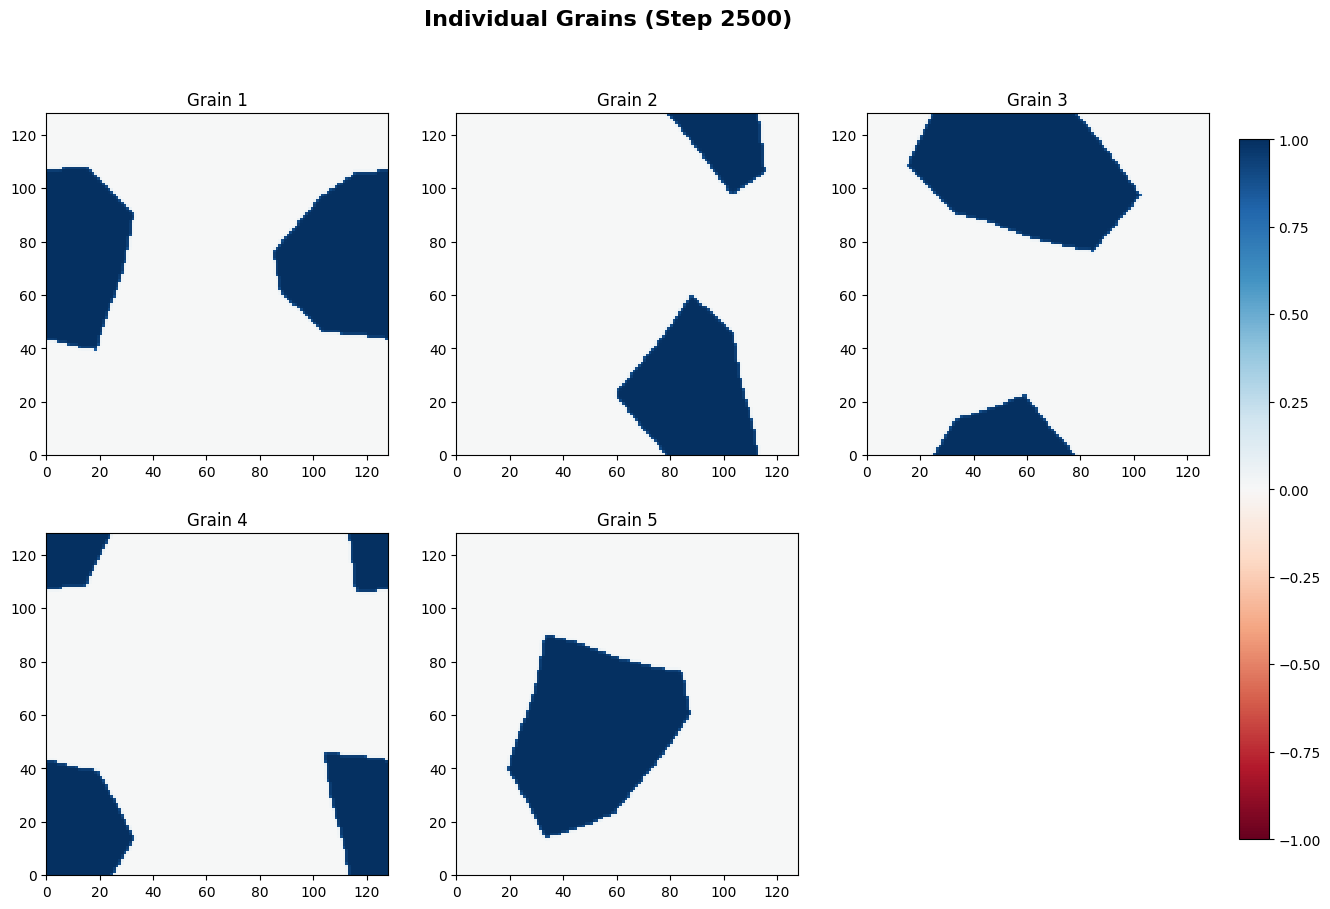

Visualizing combined grains (snapshots)...


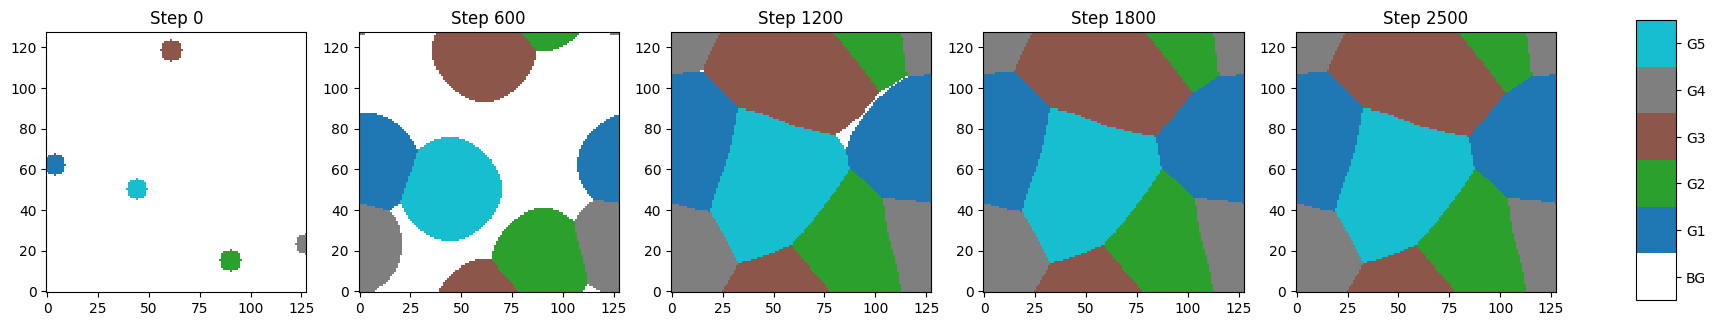

Generating animation...
Animation saved to multi_grain_growth.mp4
Total saved states: 26


In [3]:
if __name__ == "__main__":
    # 시뮬레이션 초기화
    sim = MultiGrainGrowthSimulation(
        N=128,
        num_grains=5,
        dx=1.0,
        dt=0.01,
        grad_coeff=0.1,
        mobility=5.0,
        p_coeff=2.0,
        radius=5,
        pbc_x=True,
        pbc_y=True,
        random_seed=25  # 재현성을 위해 seed 설정
    )

    # 시뮬레이션 실행 (100 스텝마다 저장)
    print("Running multi-grain growth simulation...")
    nsteps = 2500
    sim.run_simulation(nsteps=nsteps, save_interval=100)

    # 방법 1: 개별 그레인 시각화
    print("Visualizing individual grains...")
    sim.visualize_individual_grains(snapshot_index=-1, num_cols=3)

    # 방법 2: 합성 view 시각화 (1×5 배열)
    print("Visualizing combined grains (snapshots)...")
    sim.visualize_combined_view(num_snapshots=5)

    # 방법 3: 애니메이션으로 저장
    print("Generating animation...")
    sim.visualize_animation(output_filename='multi_grain_growth.mp4', fps=10)

    print(f"Total saved states: {len(sim.phi_history)}")